# Pre-eQTL analysis 0ppm vs. 1500ppm samples data wrangling

__Author:__ Bryan Quach  
__Date:__ April 27, 2017

## Objective: Create phenotype and design matrices for eQTL analysis

The eQTL software requires as input a [design matrix](https://en.wikipedia.org/wiki/Design_matrix) and a phenotype matrix. This document outlines the steps we take in generating the matrices for downstream tissue-specific eQTL analyses focused on comparisons between 0ppm and 1500ppm 1,3-butadiene exposure samples.

### Estimated Analysis Time: <1 days

## Software

* [DESeq2 (R package)](http://www.bioconductor.org/packages/release/bioc/html/DESeq2.html)

## Analysis Outline

* Creating tissue-specific phenotype matrices
* Creating tissue-specific covariate matrices

## Phenotype matrix construction

The phenotype we have is gene expression values in liver, lung, and kidney tissue. We start with RSEM derived data lists that contain raw counts and relative abundance estimates (transcripts per million). In downstream eQTL analyses we will be treating samples from the same CC mouse strain as the same "individual". By doing so we can consider a BD treatment effect within an individual as the difference between the gene expression values between samples. For example, for a gene A in strain CC001, the treatment effect would be the difference in gene expression value for gene A between sample 1 (1500ppm) and 2 (0ppm) where both samples are from CC001 mice. We will refer to this phenotype as "delta expression".

In previous preliminary analyses, we used TPM values as the phenotype. A google search for clarifying the details of TPM calculations shows that TPM values are a within sample normalization and provides relative abundances of transcript levels within a sample, but their across samples values are more stable than RPKM. Regardless, it is not recommended to compare TPM values across samples when the goal is to understand differences in absolute expression. A [discussion thread](https://groups.google.com/forum/#!topic/rsem-users/jJaeaSRG1eo) that includes the authors of RSEM suggests that TPM values are comparable across samples if interpreted correctly. If the comparison is understood in terms of relative abundances instead of absolute levels then cross-sample comparisons are fine. The interpretation would be that the relative abundance of a gene A in sample 1 is greater than/less than the relative abundance of gene A in sample 2. In terms of the delta expression, using TPM would mean that we are looking at the change in relative abundance of gene A following BD treatment.

I am inclined to think though that we are more interested in changes in absolute levels of gene expression between samples. In this case, between sample normalization would be more appropriate. As described [here](https://haroldpimentel.wordpress.com/2014/12/08/in-rna-seq-2-2-between-sample-normalization/), between-sample normalization methods try to make the read counts for a single gene more comparable across samples of varying sequencing depths.

For our delta expression phenotype, we will combine both within sample and between sample normalization. This will allow us to more apprioriately set a global gene filtering threshold and calculate differences between samples. We will first take RSEM TPM values and normalize them using DESeq2's median ratio normalization. Following this we will calculate the difference of the normalized TPMs between matched samples (1500ppm and 0ppm treated mice from the same strain).

In [1]:
library(DESeq2)

#Load TPM data
load("data/tpm_data.original.Rdata")
all.tpm <- cbind(txi.rsem.htsf$abundance, txi.rsem.tamu$abundance, txi.rsem.merged$abundance)

#Reformat sample names
sample.names <- sapply(strsplit(x=colnames(all.tpm), split='_'), function(x){paste0(x[1:3],collapse="_")})
colnames(all.tpm) <- sample.names

#Separate samples by tissue type and filter out 625ppm samples
filtered.tpm <- all.tpm[,!grepl(colnames(all.tpm), pattern="_625ppm_", ignore.case=T)]
kidney.tpm <- filtered.tpm[,grepl(colnames(filtered.tpm), pattern="kidney", ignore.case=T)]
liver.tpm <- filtered.tpm[,grepl(colnames(filtered.tpm), pattern="liver", ignore.case=T)]
lung.tpm <- filtered.tpm[,grepl(colnames(filtered.tpm), pattern="lung", ignore.case=T)]

#Apply median ratio normalization per tissue
lung.size.factors <- estimateSizeFactorsForMatrix(lung.tpm)
liver.size.factors <- estimateSizeFactorsForMatrix(liver.tpm)
kidney.size.factors <- estimateSizeFactorsForMatrix(kidney.tpm)
lung.norm.tpm <- sweep(lung.tpm, 2, lung.size.factors, "/")
liver.norm.tpm <- sweep(liver.tpm, 2, liver.size.factors, "/")
kidney.norm.tpm <- sweep(kidney.tpm, 2, kidney.size.factors, "/")

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min


Attaching packag

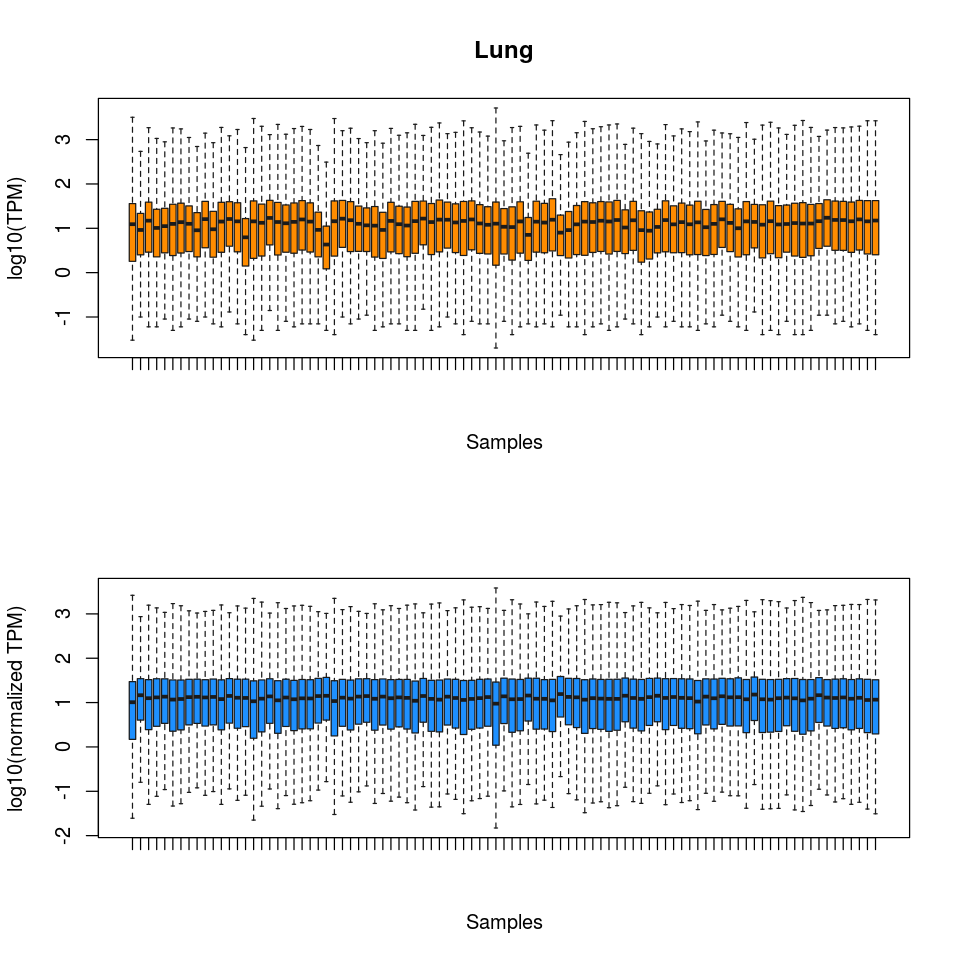

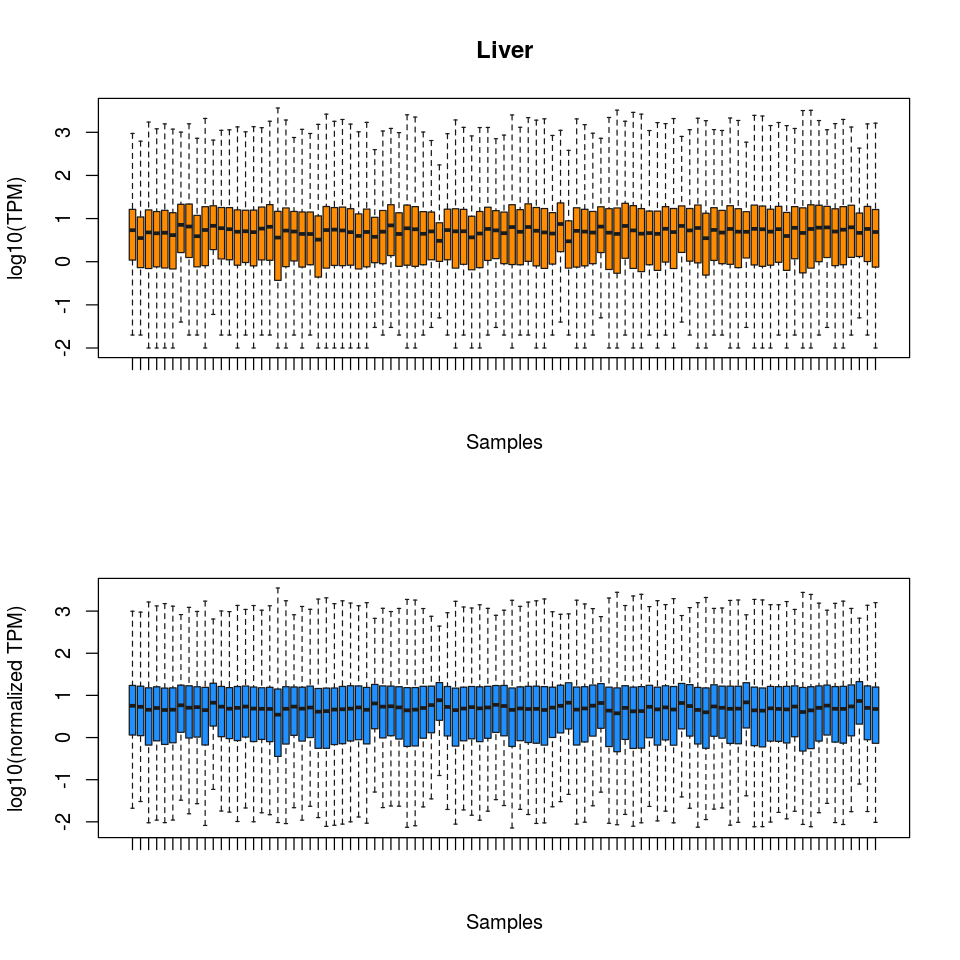

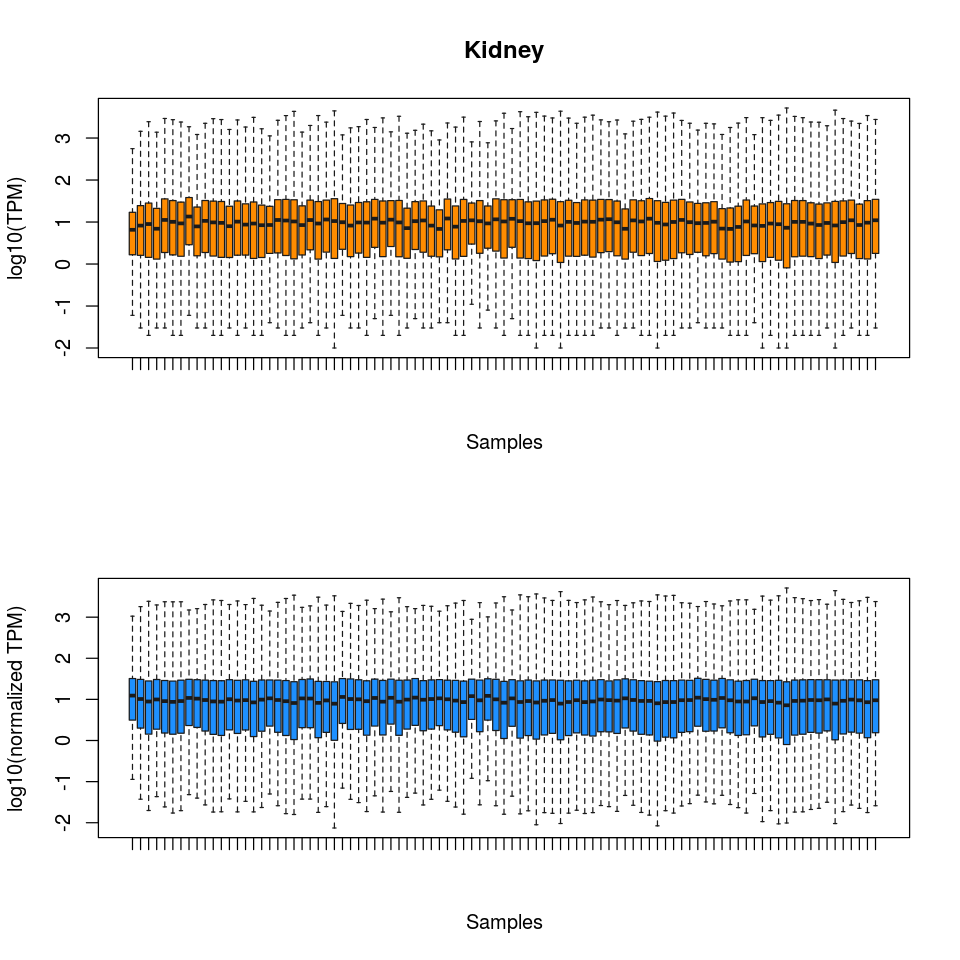

In [2]:
#Visualize before and after normalization
options(repr.plot.width=8, repr.plot.height=8)

#Lung
log.lung.tpm <- log10(lung.tpm)
log.lung.norm.tpm <- log10(lung.norm.tpm)
is.na(log.lung.tpm) <- sapply(log.lung.tpm, is.infinite)
is.na(log.lung.norm.tpm) <- sapply(log.lung.norm.tpm, is.infinite)
par(mfrow=c(2,1))
boxplot(log.lung.tpm, names=NA, outline=F, 
        col="darkorange", border="gray10", 
        ylab="log10(TPM)", xlab="Samples", main="Lung")
boxplot(log.lung.norm.tpm, names=NA, outline=F, 
        col="dodgerblue", border="gray10", 
        ylab="log10(normalized TPM)", xlab="Samples")

#Liver
log.liver.tpm <- log10(liver.tpm)
log.liver.norm.tpm <- log10(liver.norm.tpm)
is.na(log.liver.tpm) <- sapply(log.liver.tpm, is.infinite)
is.na(log.liver.norm.tpm) <- sapply(log.liver.norm.tpm, is.infinite)
par(mfrow=c(2,1))
boxplot(log.liver.tpm, names=NA, outline=F, 
        col="darkorange", border="gray10", 
        ylab="log10(TPM)", xlab="Samples", main="Liver")
boxplot(log.liver.norm.tpm, names=NA, outline=F, 
        col="dodgerblue", border="gray10", 
        ylab="log10(normalized TPM)", xlab="Samples")

#Kidney
log.kidney.tpm <- log10(kidney.tpm)
log.kidney.norm.tpm <- log10(kidney.norm.tpm)
is.na(log.kidney.tpm) <- sapply(log.kidney.tpm, is.infinite)
is.na(log.kidney.norm.tpm) <- sapply(log.kidney.norm.tpm, is.infinite)
par(mfrow=c(2,1))
boxplot(log.kidney.tpm, names=NA, outline=F, 
        col="darkorange", border="gray10", 
        ylab="log10(TPM)", xlab="Samples", main="Kidney")
boxplot(log.kidney.norm.tpm, names=NA, outline=F, 
        col="dodgerblue", border="gray10", 
        ylab="log10(normalized TPM)", xlab="Samples")

Since our eQTL analyses will use 0ppm and 1500ppm samples only, we will remove the 625ppm samples. Additionally, only CC strains with matched 0ppm and 1500ppm samples will be included.

In [3]:
#Separate samples into 0ppm and 1500ppm samples
lung.bd0.tpm <- lung.norm.tpm[,grepl(colnames(lung.norm.tpm), pattern="_0ppm_", ignore.case=T)]
lung.bd1500.tpm <- lung.norm.tpm[,grepl(colnames(lung.norm.tpm), pattern="_1500ppm_", ignore.case=T)]
liver.bd0.tpm <- liver.norm.tpm[,grepl(colnames(liver.norm.tpm), pattern="_0ppm_", ignore.case=T)]
liver.bd1500.tpm <- liver.norm.tpm[,grepl(colnames(liver.norm.tpm), pattern="_1500ppm_", ignore.case=T)]
kidney.bd0.tpm <- kidney.norm.tpm[,grepl(colnames(kidney.norm.tpm), pattern="_0ppm_", ignore.case=T)]
kidney.bd1500.tpm <- kidney.norm.tpm[,grepl(colnames(kidney.norm.tpm), pattern="_1500ppm_", ignore.case=T)]

#Load mouse ID to strain map
id.strain.map <- read.delim("../../id_strain_map.txt", header=T)
id.strain.map$ID <- as.numeric(id.strain.map$ID)

#Retain only matched samples
find.matches <- function(bd0.tpm, bd1500.tpm, id.strain.map){
    bd0.ids <- sapply(colnames(bd0.tpm), function(x){as.numeric(strsplit(x=x, split="_")[[1]][3])})
    bd1500.ids <- sapply(colnames(bd1500.tpm), function(x){as.numeric(strsplit(x=x, split="_")[[1]][3])})
    bd0.strains <- id.strain.map$Strain[sapply(bd0.ids, function(x){which(id.strain.map$ID==x)})]
    bd1500.strains <- id.strain.map$Strain[sapply(bd1500.ids, function(x){which(id.strain.map$ID==x)})]
    matched.strains <- sort(intersect(bd0.strains, bd1500.strains))
    bd0.indices <- sapply(matched.strains, function(x){which(bd0.strains==x)})
    bd1500.indices <- sapply(matched.strains, function(x){which(bd1500.strains==x)})
    return(list(bd0=bd0.indices, bd1500=bd1500.indices))
}
lung.keep <- find.matches(lung.bd0.tpm, lung.bd1500.tpm, id.strain.map)
liver.keep <- find.matches(liver.bd0.tpm, liver.bd1500.tpm, id.strain.map)
kidney.keep <- find.matches(kidney.bd0.tpm, kidney.bd1500.tpm, id.strain.map)
lung.bd0.tpm <- lung.bd0.tpm[,lung.keep$bd0]
liver.bd0.tpm <- liver.bd0.tpm[,liver.keep$bd0]
kidney.bd0.tpm <- kidney.bd0.tpm[,kidney.keep$bd0]
lung.bd1500.tpm <- lung.bd1500.tpm[,lung.keep$bd1500]
liver.bd1500.tpm <- liver.bd1500.tpm[,liver.keep$bd1500]
kidney.bd1500.tpm <- kidney.bd1500.tpm[,kidney.keep$bd1500]

#Sanity check - matrices of same tissue should be equal dimension
dim(kidney.bd0.tpm)
dim(kidney.bd1500.tpm)
dim(liver.bd0.tpm)
dim(liver.bd1500.tpm)
dim(lung.bd0.tpm)
dim(lung.bd1500.tpm)

[1] 24423    43

[1] 24423    43

[1] 24423    43

[1] 24423    43

[1] 24423    43

[1] 24423    43

In our eQTL analyses we will be looking for treatment associated genetic variation, so we create a new phenotype, delta expression. This phenotype will simply be the difference between the gene expression levels in 1500ppm samples and 0ppm samples (matched by strain). We also want to filter out genes where the variance in treatment effect is small, so we look at the distributions of delta expression to determine an appropriate cutoff for this filtering.

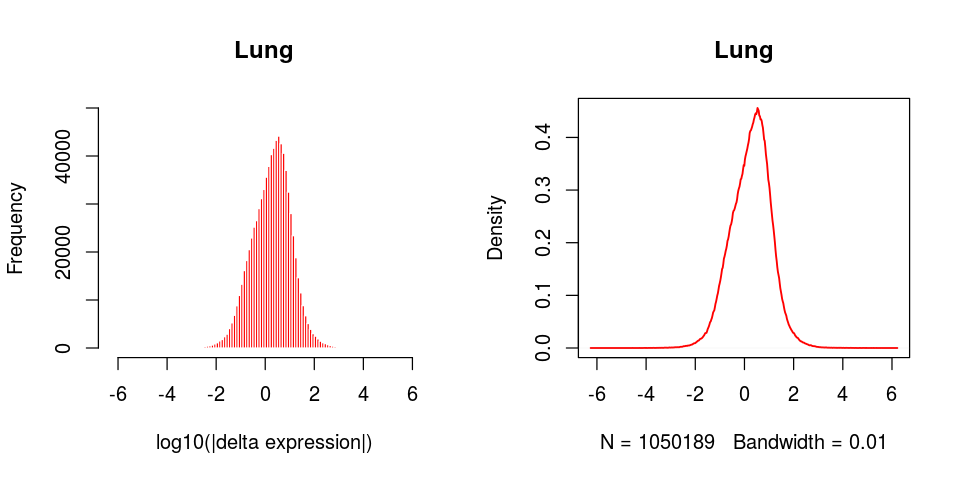

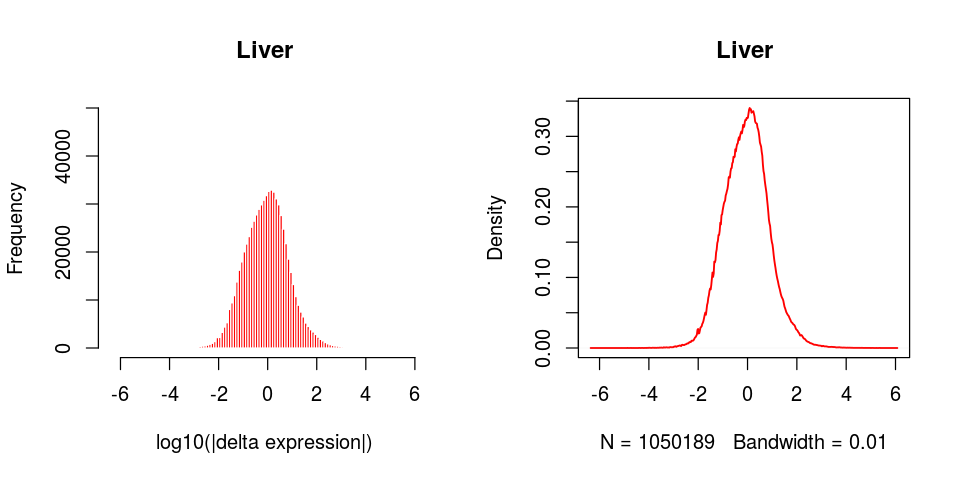

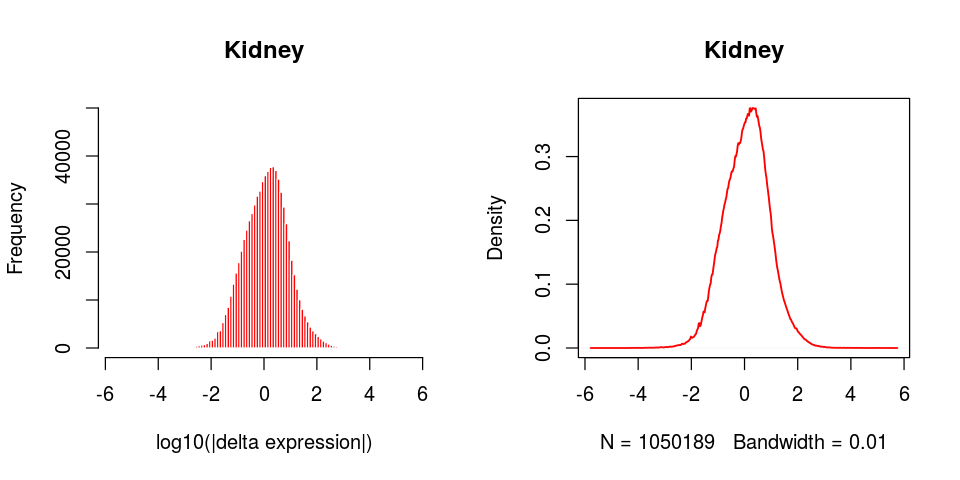

In [4]:
#Make delta matrices
delta.lung <- lung.bd1500.tpm - lung.bd0.tpm
delta.liver <- liver.bd1500.tpm - liver.bd0.tpm
delta.kidney <- kidney.bd1500.tpm - kidney.bd0.tpm

#Plot delta expression distributions
options(repr.plot.width=8, repr.plot.height=4)
#Lung
par(mfrow=c(1,2))
hist(log10(abs(delta.lung)), breaks=100, border="white", col="red", ylim=c(0,50000),
     xlab="log10(|delta expression|)", main="Lung")
plot(density(log10(abs(delta.lung)), bw=0.01), main="Lung", col="red", lwd=1.5)

#Liver
par(mfrow=c(1,2))
hist(log10(abs(delta.liver)), breaks=100, border="white", col="red", ylim=c(0,50000),
     xlab="log10(|delta expression|)", main="Liver")
plot(density(log10(abs(delta.liver)), bw=0.01), main="Liver", col="red", lwd=1.5)

#Kidney
par(mfrow=c(1,2))
hist(log10(abs(delta.kidney)), breaks=100, border="white", col="red", ylim=c(0,50000),
     xlab="log10(|delta expression|)", main="Kidney")
plot(density(log10(abs(delta.kidney)), bw=0.01), main="Kidney", col="red", lwd=1.5)


From the above distributions, we see that approximately half of the delta expresssion values are less than 1. Another interpretation of this is that exposure to 1,3-butadiene does not cause more than a 1 normalized TPM change in gene expression for ~50% of all values (each value represents a gene-sample pair). Although we may be filtering out a large number of genes, we will apply a filtering criterion of >1 delta expression value in at least 5% of samples for a gene.

In [5]:
#Filter out genes with small treatment effects
kidney.keep <- apply(delta.kidney, 1, function(y){length(which(y>1))}) >= 0.05*ncol(delta.kidney)
liver.keep <- apply(delta.liver, 1, function(y){length(which(y>1))}) >= 0.05*ncol(delta.liver)
lung.keep <- apply(delta.lung, 1, function(y){length(which(y>1))}) >= 0.05*ncol(delta.lung)
delta.kidney <- t(delta.kidney[kidney.keep,])
delta.liver <- t(delta.liver[liver.keep,])
delta.lung <- t(delta.lung[lung.keep,])

dim(delta.kidney)
dim(delta.liver)
dim(delta.lung)

[1]    43 13288

[1]    43 10608

[1]    43 15330

By this point the matrices of counts are almost in the correct form for use with the eQTL software. Once we have created the covariate matrices, we can convert everything into the final format. 

## Covariate matrix construction

The covariate matrices that we construct should contain the following information for each sample:

* Sample ID - we use CC strain ID for this
* Sequencing center location
* Sequencing batch
* Haplotype dosages for every marker

For now we are undecided on how sequencing center and batch will be incorporated since the matched samples may come from different batches and centers. As a temporary solution, we use NA values for those columns of covariate matrix.

In [7]:
#Load sequencing center labels
seq.center <- read.delim("../sequencing_center_info.txt", header=F)
seq.center <- cbind(seq.center, sapply(seq.center[,1], function(x){strsplit(as.character(x), split="_")[[1]][3]}))
colnames(seq.center) <- c("Sample","Center","ID")

#Load batch labels and add to partial covariate matrix
batch <- read.delim("../batch_info.txt", header=F)
batch.indices <- sapply(seq.center$Sample, function(x){which(batch[,1]==x)})
cov.data <- cbind(seq.center, batch[batch.indices,2])

#Load mouse ID to strain map
id.strain.map <- read.delim("../../id_strain_map.txt", header=T)
id.strain.map$ID <- as.numeric(id.strain.map$ID)
#Add strain labels to seq.center and reorder columns
sample.info <- cbind(cov.data, id.strain.map$Strain[sapply(seq.center$ID, function(x){which(id.strain.map$ID==x)})])
sample.info <- sample.info[,c(1,3,5,2,4)]
colnames(sample.info) <- c("Sample", "ID", "Strain", "Center","Batch")

#Load haplotype dosage matrix
dosages <- readRDS("../../genotype/20170331_covariate_matrix/results/dosage_covariate_matrix.rds")

#Create covariate matrices for each tissue
#### NOTE: This code is for potential future use. Currently the eQTL software requires the following covariate names - ID, Center, Batch ####
#kidney.bd0.info <- sample.info[sapply(colnames(kidney.bd0.tpm), function(x){which(sample.info$Sample==x)}),][,c("Strain","Center","Batch")]
#kidney.bd1500.info <- sample.info[sapply(colnames(kidney.bd1500.tpm), function(x){which(sample.info$Sample==x)}),][,c("Center","Batch")]
#kidney.dosages <- dosages[sapply(kidney.bd0.info$Strain, function(x){which(rownames(dosages)==x)}),]
#kidney.covdata <- cbind(kidney.bd0.info, kidney.bd1500.info, kidney.dosages)
#colnames(kidney.covdata)[2:5] <- c("Center.0ppm", "Batch.0ppm", "Center.1500ppm", "Batch.1500ppm")
#
#liver.bd0.info <- sample.info[sapply(colnames(liver.bd0.tpm), function(x){which(sample.info$Sample==x)}),][,c("Strain","Center","Batch")]
#liver.bd1500.info <- sample.info[sapply(colnames(liver.bd1500.tpm), function(x){which(sample.info$Sample==x)}),][,c("Center","Batch")]
#liver.dosages <- dosages[sapply(liver.bd0.info$Strain, function(x){which(rownames(dosages)==x)}),]
#liver.covdata <- cbind(liver.bd0.info, liver.bd1500.info, liver.dosages)
#colnames(liver.covdata)[2:5] <- c("Center.0ppm", "Batch.0ppm", "Center.1500ppm", "Batch.1500ppm")
#
#lung.bd0.info <- sample.info[sapply(colnames(lung.bd0.tpm), function(x){which(sample.info$Sample==x)}),][,c("Strain","Center","Batch")]
#lung.bd1500.info <- sample.info[sapply(colnames(lung.bd1500.tpm), function(x){which(sample.info$Sample==x)}),][,c("Center","Batch")]
#lung.dosages <- dosages[sapply(lung.bd0.info$Strain, function(x){which(rownames(dosages)==x)}),]
#lung.covdata <- cbind(lung.bd0.info, lung.bd1500.info, lung.dosages)
#colnames(lung.covdata)[2:5] <- c("Center.0ppm", "Batch.0ppm", "Center.1500ppm", "Batch.1500ppm")

kidney.info <- sample.info[sapply(colnames(kidney.bd0.tpm), function(x){which(sample.info$Sample==x)}),][,c("Strain","Center","Batch")]
kidney.dosages <- dosages[sapply(kidney.info$Strain, function(x){which(rownames(dosages)==x)}),]
kidney.covdata <- cbind(kidney.info, kidney.dosages)
kidney.covdata[2:3] <- NA

liver.info <- sample.info[sapply(colnames(liver.bd0.tpm), function(x){which(sample.info$Sample==x)}),][,c("Strain","Center","Batch")]
liver.dosages <- dosages[sapply(liver.info$Strain, function(x){which(rownames(dosages)==x)}),]
liver.covdata <- cbind(liver.info, liver.dosages)
liver.covdata[2:3] <- NA

lung.info <- sample.info[sapply(colnames(lung.bd0.tpm), function(x){which(sample.info$Sample==x)}),][,c("Strain","Center","Batch")]
lung.dosages <- dosages[sapply(lung.info$Strain, function(x){which(rownames(dosages)==x)}),]
lung.covdata <- cbind(lung.info, lung.dosages)
lung.covdata[2:3] <- NA

## Matrix reformatting and saving

With the expression matrices and covariate matrices in the right structure, we rename the strain column to "ID" as required by the eQTL software, rename the rows of the expression matrices to be strain names, and save the matrices to files.

In [8]:
colnames(kidney.covdata)[1] <- "ID"
colnames(liver.covdata)[1] <- "ID"
colnames(lung.covdata)[1] <- "ID"
rownames(delta.kidney) <- sample.info[sapply(rownames(delta.kidney), function(x){which(sample.info$Sample==x)}),][,"Strain"]
rownames(delta.liver) <- sample.info[sapply(rownames(delta.liver), function(x){which(sample.info$Sample==x)}),][,"Strain"]
rownames(delta.lung) <- sample.info[sapply(rownames(delta.lung), function(x){which(sample.info$Sample==x)}),][,"Strain"]

#Matrix size sanity check - each should be strain x gene/covariate
#Covariate matrices should be equal width
dim(delta.kidney)
dim(delta.liver)
dim(delta.lung)
dim(kidney.covdata)
dim(liver.covdata)
dim(lung.covdata)

#Save matrices
saveRDS(object=delta.kidney, file="results/expmat_0ppm_vs_1500ppm_kidney.rds")
saveRDS(object=delta.liver, file="results/expmat_0ppm_vs_1500ppm_liver.rds")
saveRDS(object=delta.lung, file="results/expmat_0ppm_vs_1500ppm_lung.rds")
saveRDS(object=kidney.covdata, file="results/covdata_0ppm_vs_1500ppm_kidney.rds")
saveRDS(object=liver.covdata, file="results/covdata_0ppm_vs_1500ppm_liver.rds")
saveRDS(object=lung.covdata, file="results/covdata_0ppm_vs_1500ppm_lung.rds")

[1]    43 13288

[1]    43 10608

[1]    43 15330

[1]     43 621779

[1]     43 621779

[1]     43 621779